In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import warnings
import concurrent.futures
from datetime import datetime

In [2]:
# Ignore SSL warnings
warnings.filterwarnings("ignore", message="Unverified HTTPS request")

# Configuration
LOG_FILE = "extract_logos_log.txt"  # Log file path
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}
sites_without_logo = 0
sites_with_logo = 0
total_sites = 0



In [3]:
#  Function to log messages
def log_progress(message):
    """Logs messages with timestamps to a log file."""
    timestamp_format = '%Y-%m-%d %H:%M:%S'  # Year-Month-Day Hour:Minute:Second
    now = datetime.now()  # Get current timestamp
    timestamp = now.strftime(timestamp_format)
    with open(LOG_FILE, "a") as f:
        f.write(f"{timestamp} : {message}\n")
    print(message)  # Also print to console for real-time monitoring


In [4]:
# Function to find the first logo on a website
def extract_logo(url):
    site_name = urlparse(url).netloc.replace("www.", "")

    try:
        response = requests.get(url, headers=headers, timeout=20, verify=False)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")

        #Step 1: Try finding a normal logo first
        logo_candidates = soup.find_all("img", src=True)
        for img in logo_candidates:
            src = img["src"]
            srcset = img.get("srcset", "")
            alt_text = img.get("alt", "").lower()
            class_text = " ".join(img.get("class", [])).lower()
            id_text = img.get("id", "").lower()
            title_text = img.get("title", "").lower()
            aria_label = img.get("aria-label", "").lower()

            if src.startswith("//"):
                img_url = "https:" + src
            else:
                img_url = urljoin(url, src)

            if srcset:
                srcset_urls = [urljoin(url, s.split(" ")[0]) for s in srcset.split(",")]
                img_url = srcset_urls[-1]

            # Conditions to identify a logo
            if "logo" in src.lower() or \
               any(keyword in alt_text for keyword in ["logo", "brand", "header", "footer"]) or \
               any(keyword in class_text for keyword in ["logo", "brand", "header", "footer"]) or \
               any(keyword in id_text for keyword in ["logo", "brand", "header", "footer"]) or \
               any(keyword in title_text for keyword in ["logo", "brand"]) or \
               any(keyword in aria_label for keyword in ["logo", "brand"]):

                logo_data.append({"site": site_name, "logo_url": img_url})
                log_progress(f" Found image logo for {site_name}: {img_url}")
                return  # Stop searching once we find a valid logo

        # Step 2: If no normal logo is found, try using favicon
        favicons = soup.find_all("link", rel=["icon", "shortcut icon"])
        for icon in favicons:
            icon_url = urljoin(url, icon.get("href"))
            logo_data.append({"site": site_name, "logo_url": icon_url})
            log_progress(f" Using favicon for {site_name}: {icon_url}")
            return

        #  Step 3: No logo or favicon found
        log_progress(f" No logo found for {url}")

    except requests.RequestException as e:
        log_progress(f" Error accessing {url}: {e}")
    except Exception as e:
        log_progress(f" Unknown error for {url}: {e}")


 Starting scraping for 3416 websites in parallel mode...
 Error accessing https://ymcasteuben.org: HTTPSConnectionPool(host='ymcasteuben.org', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
 Error accessing https://astrazeneca.ua: HTTPSConnectionPool(host='astrazeneca.ua', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7a56dba84750>: Failed to resolve 'astrazeneca.ua' ([Errno -2] Name or service not known)"))
 Error accessing https://unicharm.com.br: HTTPSConnectionPool(host='unicharm.com.br', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7a56cb76d690>: Failed to resolve 'unicharm.com.br' ([Errno -5] No address associated with hostname)"))
 Error accessing https://xella-colloquium.berlin: HTTPSConnectionPool(host='xella-

 Found image logo for ford.vn.ua: https://ford.vn.ua/v163/bundles/app/images/ford-logo.svg
 Using favicon for mazda-autohaus-tabbouch-speyer.de: https://www.assets.mazda-autohaus.de/assets/img/favicons/favicon-32x32.png
 Found image logo for engie.de: https://engie.de/sites/default/themes/karoshi_premium/images/logo.svg
 Found image logo for mitsubishi-motors.com.om: https://mitsubishi-motors.com.om/content/dam/mitsubishi-motors/images/logos/nav-logo-light.svg
 Found image logo for toysrus.com.sg: https://toysrus.com.sg/on/demandware.static/Sites-ToysRUs_SG-Site/-/default/dw11a60868/images/logo/tru.svg
 Found image logo for aamcofeastervillepa.com: https://aamcofeastervillepa.com/images/logo.png
 Using favicon for mazda.de: https://mazda.de/favicon-48x48.png
 Found image logo for modshair-nuernberg.de: https://www.modshair-nuernberg.de/wp-content/uploads/2023/01/logo-dark.png
 Using favicon for daikin.com.vn: https://daikin.com.vn/favicon.ico
 No logo found for https://toyotafocsani.ro
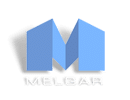
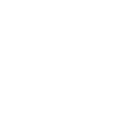
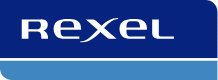
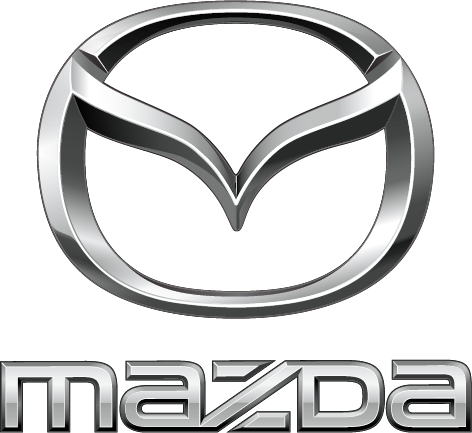
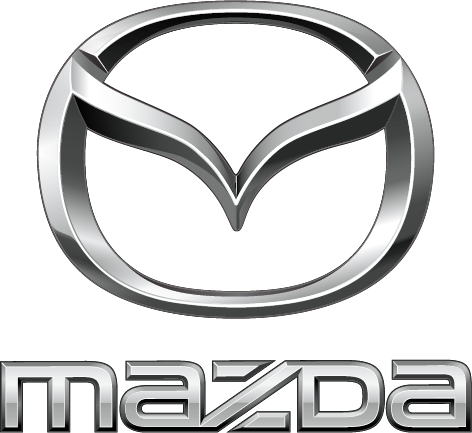
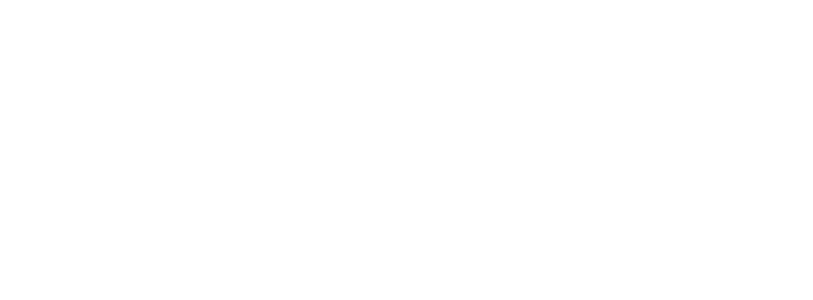

In [6]:
# Load domains from .xlsx file
file_path = 'logos.xlsx'
df = pd.read_excel(file_path)

#  Store results in a list (will be converted to DataFrame later)
logo_data = []

# Remove duplicates based on 'domain' column
df = df.drop_duplicates(subset=['domain'])
domains = df['domain'].tolist()

# Create complete URLs
base_urls = ["https://" + domain for domain in domains]
total_sites = len(base_urls)

#  Run extraction in parallel using ThreadPoolExecutor
log_progress(f" Starting scraping for {total_sites} websites in parallel mode...")
MAX_THREADS = 70  # Adjust based on system

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    executor.map(extract_logo, base_urls)

# Convert results to DataFrame and save as .parquet
logo_df = pd.DataFrame(logo_data)
logo_df.to_parquet("logos.parquet", index=False)
log_progress(" Logos successfully saved to logos.parquet")

#  Final Statistics (Calculated dynamically)
sites_with_logo = len(logo_df)
sites_without_logo = total_sites - sites_with_logo
success_rate = (sites_with_logo / total_sites) * 100 if total_sites > 0 else 0

#  Count favicon occurrences
favicon_count = logo_df[logo_df["logo_url"].str.contains("favicon", na=False)]
total_favicons = len(favicon_count)

#  Log final statistics
log_progress("\n Final Statistics:")
log_progress(f"Total sites: {total_sites}")
log_progress(f" Sites with logo: {sites_with_logo}")
log_progress(f" Sites without logo: {sites_without_logo}")
log_progress(f" Success rate: {success_rate:.2f}%")
log_progress(f" Total favicon logos detected: {total_favicons} ({(total_favicons / sites_with_logo) * 100:.2f}%)")
